In [1]:
# 1. RGB 이미지에서 DINOv2 특징 추출
# 2. 2D keypoints 예측 MLP 학습
# 3. Joiot angle 예측 MLP 학습
# 4. Fk로 3D 포즈 계산
# 5. 3D 포즈와 2D keypoints PnP로 카메라 포즈 계산
# 6. Extrinsic Matrix 계산 및 저장

In [6]:
import os
import glob
import json
import numpy as np
import random
import wandb

import cv2
import math
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm 

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

NUM_ANGLES = 6
NUM_JOINTS = 7
FEATURE_DIM = 768
HEATMAP_SIZE = (128, 128)

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
is_available = torch.cuda.is_available()

if is_available:
    # 2. 사용 가능한 GPU 개수 확인
    gpu_count = torch.cuda.device_count()
    print(f"✅ 사용 가능한 GPU가 감지되었습니다.")
    print(f"GPU 개수: {gpu_count}개")
    
# --- 기본 설정 ---
serial_number = {"top": '30779426', "right": '34850673', "left": '38007749'}
number_of_trial = [1, 2, 3, 4, 5, 6, 7]
camera_types = ['right', 'left']
base_path = '../dataset/Fr5'

# 최종 데이터 쌍을 저장할 리스트
dataset_pairs = []

# --- 타임스탬프 추출 함수 ---
def extract_timestamp_from_path(file_path):
    """파일 경로에서 타임스탬프(float)를 추출합니다."""
    try:
        # 파일명만 분리 (e.g., zed_38007749_left_1748248972.419.jpg)
        filename = os.path.basename(file_path)
        # 확장자 제거 (e.g., zed_38007749_left_1748248972.419)
        filename_no_ext = os.path.splitext(filename)[0]
        # '_'로 분리 후 마지막 부분을 타임스탬프로 간주
        timestamp_str = filename_no_ext.split('_')[-1]
        return float(timestamp_str)
    except (ValueError, IndexError) as e:
        print(f"Warning: Could not extract timestamp from {file_path}. Error: {e}")
        return None

# --- 메인 루프 ---
for key, serial in serial_number.items():
    for trial in number_of_trial:
        for cam in camera_types:
            print(f"Processing: trial {trial}, camera '{key}', cam_type '{cam}'")
            
            # 1. 현재 trial과 key에 해당하는 모든 이미지와 joint 파일 경로 수집
            image_dir = f"{base_path}/Fr5_{trial}th_250526/{key}/"
            joint_dir = f"{base_path}/Fr5_{trial}th_250526/joint/"

            # glob을 사용하여 와일드카드(*)가 포함된 모든 파일 검색
            image_paths = glob.glob(f"{image_dir}zed_{serial}_{cam}_*.jpg")
            # joint 파일은 serial 번호로만 검색
            joint_paths = glob.glob(f"{joint_dir}joint_{serial}_*.json")

            if not image_paths or not joint_paths:
                print(f"  -> Skipping: Not enough files found (images: {len(image_paths)}, joints: {len(joint_paths)})")
                continue

            # 2. Joint 파일들의 타임스탬프를 미리 추출하여 리스트로 저장 (효율성 증대)
            joint_timestamps = np.array([extract_timestamp_from_path(p) for p in joint_paths])
            
            # 3. 각 이미지에 대해 가장 가까운 joint 파일 매칭
            for img_path in image_paths:
                img_ts = extract_timestamp_from_path(img_path)
                if img_ts is None:
                    continue

                # Numpy를 사용하여 모든 joint 타임스탬프와의 차이를 한 번에 계산
                time_diffs = np.abs(joint_timestamps - img_ts)
                
                # 차이가 가장 작은 값의 인덱스(위치)를 찾음
                min_diff_idx = np.argmin(time_diffs)
                
                # 가장 가까운 joint 파일 경로 선택
                best_joint_path = joint_paths[min_diff_idx]
                
                # 최종 데이터 쌍에 추가
                dataset_pairs.append({
                    "image_path": img_path,
                    "joint_path": best_joint_path,
                    "timestamp_diff": time_diffs[min_diff_idx]
                })

print(f"\n✅ Total {len(dataset_pairs)} pairs found.")

# --- 결과 확인 ---
if dataset_pairs:
    print("\n--- Sample of matched pairs ---")
    for i in range(min(5, len(dataset_pairs))):
        pair = dataset_pairs[i]
        print(f"Image: {os.path.basename(pair['image_path'])}")
        print(f"Joint: {os.path.basename(pair['joint_path'])}")
        print(f"Time Difference: {pair['timestamp_diff']:.6f} seconds\n")

✅ 사용 가능한 GPU가 감지되었습니다.
GPU 개수: 1개
Processing: trial 1, camera 'top', cam_type 'right'
  -> Skipping: Not enough files found (images: 0, joints: 0)
Processing: trial 1, camera 'top', cam_type 'left'
  -> Skipping: Not enough files found (images: 0, joints: 0)
Processing: trial 2, camera 'top', cam_type 'right'
  -> Skipping: Not enough files found (images: 0, joints: 0)
Processing: trial 2, camera 'top', cam_type 'left'
  -> Skipping: Not enough files found (images: 0, joints: 0)
Processing: trial 3, camera 'top', cam_type 'right'
  -> Skipping: Not enough files found (images: 0, joints: 0)
Processing: trial 3, camera 'top', cam_type 'left'
  -> Skipping: Not enough files found (images: 0, joints: 0)
Processing: trial 4, camera 'top', cam_type 'right'
  -> Skipping: Not enough files found (images: 0, joints: 0)
Processing: trial 4, camera 'top', cam_type 'left'
  -> Skipping: Not enough files found (images: 0, joints: 0)
Processing: trial 5, camera 'top', cam_type 'right'
  -> Skipping:

In [7]:
def create_gt_heatmap(keypoint_2d, HEATMAP_SIZE, sigma):
    H, W = HEATMAP_SIZE
    x, y = keypoint_2d
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    dist_sq = (xx - x)**2 + (yy - y)**2
    exponent = dist_sq / (2 * sigma**2)
    heatmap = np.exp(-exponent)
    heatmap[heatmap < np.finfo(float).eps * heatmap.max()] = 0
    return heatmap

def get_dh_matrix(a, d, alpha, theta):
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

def angle_to_joint_coordinate(joint_angles, selected_view):
    # FR5 DH parameters (degrees and meters)
    fr5_dh_parameters = [
        {'alpha': 90,  'a': 0,     'd': 0.152, 'theta': 0},
        {'alpha': 0,   'a': -0.425,'d': 0,     'theta': 0},
        {'alpha': 0,   'a': -0.395,'d': 0,     'theta': 0},
        {'alpha': 90,  'a': 0,     'd': 0.102, 'theta': 0},
        {'alpha': -90, 'a': 0,     'd': 0.102, 'theta': 0},
        {'alpha': 0,   'a': 0,     'd': 0.100, 'theta': 0}
    ]
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (베이스)

    # 카메라 뷰에 따른 베이스 좌표계 보정 회전 정의
    view_rotations = {
        'top': R.from_euler('zyx', [-85, 0, 180], degrees=True),
        'left': R.from_euler('zyx', [180, 0, 90], degrees=True),
        'right': R.from_euler('zyx', [0, 0, 90], degrees=True)
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    base_point = np.array([[0], [0], [0], [1]])
    for i in range(6):
        params = fr5_dh_parameters[i]
        theta = joint_angles[i] + params['theta']
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta)
        T_cumulative = T_cumulative @ T_i
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
    return np.array(joint_coords_3d, dtype=np.float32)

def joint_coordinate_to_pixel_plane(joint_coords, aruco_result, camera_matrix, dist_coeffs):
    Rvec = np.array([
        math.radians(aruco_result['rvec_x']),
        math.radians(aruco_result['rvec_y']),
        math.radians(aruco_result['rvec_z'])
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    pixel_coords, _ = cv2.projectPoints(
        joint_coords, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    return pixel_coords.reshape(-1, 2)

class RobotPoseDataset(Dataset):
    def __init__(self, pairs, transform=None, HEATMAP_SIZE=(128, 128), sigma=5.0):
        self.pairs = pairs
        self.transform = transform
        self.heatmap_size = HEATMAP_SIZE
        self.sigma = sigma

        print("Loading and preprocessing metadata...")
        aruco_path = '../dataset/Fr5/Fr5_aruco_pose_summary.json'
        with open(aruco_path, 'r') as f:
            aruco_results_all = json.load(f)
        self.aruco_lookup = {f"{item['view']}_{item['cam']}": item for item in aruco_results_all}

        self.calib_lookup = {}
        calib_dir = "../dataset/Fr5/Fr5_calib_cam_from_conf"
        calib_files = glob.glob(os.path.join(calib_dir, "*.json"))
        for calib_path in calib_files:
            filename = os.path.basename(calib_path).replace("_calib.json", "")
            with open(calib_path, 'r') as f:
                self.calib_lookup[filename] = json.load(f)
        print("Metadata loaded.")

        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        # 1. 파일 경로 가져오기
        pair = self.pairs[idx]
        image_path = pair['image_path']
        joint_path = pair['joint_path']
        
        filename = os.path.basename(image_path)
        parts = filename.split('_') # zed_38007749_left_...jpg
        serial_str = parts[1]
        selected_cam = parts[2] + "cam"

        serial_to_view = {
            "38007749": "left",
            "34850673": "right",
            "30779426": "top"
        }
        selected_view = serial_to_view[serial_str]

        calib_key = f"{selected_view}_{serial_str}_{selected_cam}"
        calib = self.calib_lookup[calib_key]

        camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
        dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
        
        image = Image.open(image_path).convert('RGB')
        image_np = np.array(image)
        undistorted_image_np = cv2.undistort(image_np, camera_matrix, dist_coeffs)
        undistorted_image = Image.fromarray(undistorted_image_np)

        image_tensor = self.transform(undistorted_image)

        aruco_key = f"{selected_view}_{selected_cam}"
        aruco_result = self.aruco_lookup[aruco_key]
        
        # 3. Joint 데이터 불러오기 (json)
        with open(joint_path, 'r') as f:
            joint_angle_data = json.load(f)
            
        gt_angles = torch.tensor(joint_angle_data, dtype=torch.float32)
        joint_coords = angle_to_joint_coordinate(joint_angle_data, selected_view)
        pixel_coords = joint_coordinate_to_pixel_plane(joint_coords, aruco_result, camera_matrix, dist_coeffs)
        
        num_joints = len(pixel_coords) 
        
        # 원본 이미지 크기 (undistorted_image_np 사용)
        original_h, original_w, _ = undistorted_image_np.shape

        # 스케일링
        scaled_keypoints = np.zeros_like(pixel_coords)
        scaled_keypoints[:, 0] = pixel_coords[:, 0] * (self.heatmap_size[1] / original_w) # x좌표
        scaled_keypoints[:, 1] = pixel_coords[:, 1] * (self.heatmap_size[0] / original_h) # y좌표

        keypoints_2d = scaled_keypoints
        
        gt_heatmaps_np = np.zeros((num_joints, self.heatmap_size[0], self.heatmap_size[1]), dtype=np.float32)
        for i in range(num_joints):
            gt_heatmaps_np[i] = create_gt_heatmap(keypoints_2d[i], self.heatmap_size, self.sigma)
        
        gt_heatmaps = torch.from_numpy(gt_heatmaps_np)

        return image_tensor, gt_heatmaps, gt_angles

In [ ]:
class DINOv2Backbone(nn.Module):
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)

    def forward(self, image_tensor_batch): # 입력이 텐서 배치로 변경
        with torch.no_grad():
            features = self.model.forward_features(image_tensor_batch)
            patch_tokens = features[:, 1:, :]
        return patch_tokens
    
class JointAngleHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_angles=NUM_ANGLES, num_queries=4, nhead=8, num_decoder_layers=2):
        """
        어텐션을 사용하여 이미지 특징에서 핵심 정보를 추출하는 헤드.

        Args:
            input_dim (int): DINOv2 특징 벡터의 차원.
            num_angles (int): 예측할 관절 각도의 수.
            num_queries (int): 포즈 정보를 추출하기 위해 사용할 학습 가능한 쿼리의 수.
            nhead (int): Multi-head Attention의 헤드 수.
            num_decoder_layers (int): Transformer Decoder 레이어의 수.
        """
        super().__init__()
        
        # 1. "로봇 포즈에 대해 질문하는" 학습 가능한 쿼리 토큰 생성
        self.pose_queries = nn.Parameter(torch.randn(1, num_queries, input_dim))
        
        # 2. PyTorch의 표준 Transformer Decoder 레이어 사용
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=input_dim, 
            nhead=nhead, 
            dim_feedforward=input_dim * 4, # 일반적인 설정
            dropout=0.1, 
            activation='gelu',
            batch_first=True  # (batch, seq, feature) 입력을 위함
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # 3. 최종 각도 예측을 위한 MLP
        # 디코더를 거친 모든 쿼리 토큰의 정보를 사용
        self.angle_predictor = nn.Sequential(
            nn.LayerNorm(input_dim * num_queries),
            nn.Linear(input_dim * num_queries, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Linear(256, num_angles)
        )

    def forward(self, fused_features):
        # fused_features: DINOv2의 패치 토큰들 (B, Num_Patches, Dim)
        # self.pose_queries: 학습 가능한 쿼리 (1, Num_Queries, Dim)
        
        # 배치 사이즈만큼 쿼리를 복제
        b = fused_features.size(0)
        queries = self.pose_queries.repeat(b, 1, 1)
        
        # Transformer Decoder 연산
        # 쿼리(queries)가 이미지 특징(fused_features)에 어텐션을 수행하여
        # 포즈와 관련된 정보로 자신의 값을 업데이트합니다.
        attn_output = self.transformer_decoder(tgt=queries, memory=fused_features)
        
        # 업데이트된 쿼리 토큰들을 하나로 펼쳐서 MLP에 전달
        output_flat = attn_output.flatten(start_dim=1)
        
        return self.angle_predictor(output_flat)

In [ ]:
class TokenFuser(nn.Module):
    """
    ViT의 패치 토큰(1D 시퀀스)을 CNN이 사용하기 좋은 2D 특징 맵으로 변환하고 정제합니다.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.refine_blocks = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        # x: (B, D, H, W) 형태로 reshape된 토큰 맵
        projected = self.projection(x)
        refined = self.refine_blocks(projected)
        residual = self.residual_conv(x)
        return F.gelu(refined + residual)

class LightCNNStem(nn.Module):
    """
    UNet의 인코더처럼 고해상도의 공간적 특징(shallow features)을 
    여러 스케일로 추출하기 위한 경량 CNN.
    """
    def __init__(self):
        super().__init__()
        # 간단한 CNN 블록 구성
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/2
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/4
            nn.BatchNorm2d(32),
            nn.GELU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/8
            nn.BatchNorm2d(64),
            nn.GELU()
        )
        
    def forward(self, x):
        # x: 원본 이미지 텐서 배치 (B, 3, H, W)
        feat_4 = self.conv_block1(x)  # 1/4 스케일 특징
        feat_8 = self.conv_block2(feat_4) # 1/8 스케일 특징
        return feat_4, feat_8 # 다른 해상도의 특징들을 반환

class FusedUpsampleBlock(nn.Module):
    """
    업샘플링된 특징과 CNN 스템의 고해상도 특징(스킵 연결)을 융합하는 블록.
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.refine_conv = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x, skip_feature):
        x = self.upsample(x)
        
        # ✅ 해결책: skip_feature를 x의 크기에 강제로 맞춥니다.
        # ----------------------------------------------------------------------
        # 두 텐서의 높이와 너비가 다를 경우, skip_feature를 x의 크기로 리사이즈합니다.
        if x.shape[-2:] != skip_feature.shape[-2:]:
            skip_feature = F.interpolate(
                skip_feature, 
                size=x.shape[-2:], # target H, W
                mode='bilinear', 
                align_corners=False
            )
        # ----------------------------------------------------------------------
        
        # 이제 두 텐서의 크기가 같아졌으므로 안전하게 합칠 수 있습니다.
        fused = torch.cat([x, skip_feature], dim=1)
        return self.refine_conv(fused)
    
class UNetViTKeypointHead(nn.Module):
    def __init__(self, input_dim=768, num_joints=7, heatmap_size=(128, 128)):
        super().__init__()
        self.heatmap_size = heatmap_size
        
        # ViT 토큰을 CNN 친화적인 맵으로 변환 (이전 TokenFuser 사용)
        self.token_fuser = TokenFuser(input_dim, 256)
        
        # 디코더 블록 (스킵 연결을 사용하도록 FusedUpsampleBlock으로 교체)
        # LightCNNStem의 출력 채널들을(64, 32) 고려하여 skip_channels 설정
        self.decoder_block1 = FusedUpsampleBlock(in_channels=256, skip_channels=64, out_channels=128)
        self.decoder_block2 = FusedUpsampleBlock(in_channels=128, skip_channels=32, out_channels=64)
        
        # 추가적인 업샘플링
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # 최종 히트맵 예측 레이어
        self.heatmap_predictor = nn.Conv2d(64, num_joints, kernel_size=3, padding=1)

    def forward(self, dino_features, cnn_features):
        # dino_features: DINOv2에서 온 저해상도 의미 정보 (B, N, D)
        # cnn_features: LightCNNStem에서 온 고해상도 공간 정보 (feat_4, feat_8)
        cnn_feat_4, cnn_feat_8 = cnn_features

        # 1. DINOv2 토큰을 초기 2D 맵으로 변환
        b, n, d = dino_features.shape
        h = w = int(np.sqrt(n))
        x = dino_features.permute(0, 2, 1).reshape(b, d, h, w)
        x = self.token_fuser(x) # -> (B, 256, 37, 37)

        # 2. 디코더 업샘플링 & 융합
        # 37x37 -> 74x74, cnn_feat_8(1/8 스케일)과 융합
        x = self.decoder_block1(x, cnn_feat_8) # -> (B, 128, 74, 74)
        
        # 74x74 -> 148x148, cnn_feat_4(1/4 스케일)와 융합
        x = self.decoder_block2(x, cnn_feat_4) # -> (B, 64, 148, 148)
        
        # 3. 최종 해상도로 업샘플링 및 예측
        x = self.final_upsample(x)
        heatmaps = self.heatmap_predictor(x)
        
        # 목표 히트맵 크기로 최종 리사이즈
        return F.interpolate(heatmaps, size=self.heatmap_size, mode='bilinear', align_corners=False)

In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.refine_conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU())

    def forward(self, x):
        x = self.upsample_conv(x)
        return self.refine_conv(x)

class RefinedSimpleKeypointHead(nn.Module):
    def __init__(self, input_dim=768, num_joints=7, heatmap_size=(128, 128)):
        super().__init__()
        self.heatmap_size = heatmap_size
        
        # TokenFuser는 그대로 유지
        self.token_fuser = TokenFuser(input_dim, 256)
        
        # ✅ 개선 1: 모든 업샘플링을 UpsampleBlock으로 통일하여 일관성 및 안정성 확보
        self.decoder_blocks = nn.Sequential(
            UpsampleBlock(in_channels=256, out_channels=128),
            UpsampleBlock(in_channels=128, out_channels=64),
            UpsampleBlock(in_channels=64, out_channels=32) # 마지막 블록도 UpsampleBlock 사용
        )

        # ✅ 개선 2: 최종 예측 레이어의 커널 크기를 3x3으로 변경하여 공간 정보 활용
        self.heatmap_predictor = nn.Conv2d(32, num_joints, kernel_size=3, padding=1)

    def forward(self, fused_features):
        b, n, d = fused_features.shape
        h = w = int(np.sqrt(n))
        if h * w != n:
            raise ValueError("The number of tokens must be a perfect square.")
        
        feature_map = fused_features.permute(0, 2, 1).reshape(b, d, h, w)
        
        # 1. ViT 토큰을 CNN 친화적인 2D 맵으로 변환
        x = self.token_fuser(feature_map)
        
        # 2. 일관된 디코더 블록 통과
        x = self.decoder_blocks(x)
        
        # 3. 강화된 예측 레이어로 최종 히트맵 생성
        heatmaps = self.heatmap_predictor(x)
        
        return F.interpolate(heatmaps, size=self.heatmap_size, mode='bilinear', align_corners=False)

In [ ]:
class DINOv2PoseEstimator(nn.Module):
    def __init__(self, dino_model_name='vit_base_patch14_dinov2.lvd142m'):
        super().__init__()
        self.backbone = DINOv2Backbone(dino_model_name)
        feature_dim = self.backbone.model.embed_dim
        
        self.cnn_stem = LightCNNStem() # 경량 CNN 스템 추가
        
        self.keypoint_head = RefinedSimpleKeypointHead(input_dim=feature_dim) # 새로운 UNet-ViT 헤드
        self.angle_head = JointAngleHead(input_dim=feature_dim)     # 기존 Attention 헤드

    def forward(self, image_tensor_batch):
        # 1. 두 경로로 병렬적으로 특징 추출
        dino_features = self.backbone(image_tensor_batch)       # 의미 정보
        cnn_stem_features = self.cnn_stem(image_tensor_batch) # 공간 정보
        
        # 2. 각 헤드에 필요한 특징 전달
        predicted_heatmaps = self.keypoint_head(dino_features, cnn_stem_features)
        predicted_angles = self.angle_head(dino_features)
        
        return predicted_heatmaps, predicted_angles

In [ ]:
# ==============================================================================
# 2. 데이터셋 시각화 (Dataset Visualization)
# ==============================================================================

def visualize_dataset_sample(dataset, config, num_samples=3):
    """데이터셋의 샘플을 시각화하여 GT가 올바른지 확인합니다."""
    print("\n--- Visualizing Dataset Samples ---")
    
    # 역정규화(Un-normalization)를 위한 값
    mean = np.array(config['mean'])
    std = np.array(config['std'])

    for i in range(num_samples):
        # 랜덤 샘플 선택
        idx = random.randint(0, len(dataset) - 1)
        image_tensor, gt_heatmaps, gt_angles = dataset[idx]
        
        # 1. 이미지 텐서를 시각화를 위한 Numpy 배열로 변환
        img_np = image_tensor.numpy().transpose((1, 2, 0))
        img_np = std * img_np + mean # 역정규화
        img_np = np.clip(img_np, 0, 1)

        # 2. GT 히트맵을 하나의 이미지로 결합
        composite_heatmap = torch.sum(gt_heatmaps, dim=0).numpy()
        
        # 3. GT 히트맵에서 키포인트 좌표 추출
        keypoints = []
        h, w = gt_heatmaps.shape[1:]
        for j in range(gt_heatmaps.shape[0]):
            heatmap = gt_heatmaps[j]
            max_val_idx = torch.argmax(heatmap)
            y, x = np.unravel_index(max_val_idx.numpy(), (h, w))
            keypoints.append([x, y])
        keypoints = np.array(keypoints)

        # 키포인트 좌표를 원본 이미지 크기에 맞게 스케일링
        img_h, img_w, _ = img_np.shape
        scaled_keypoints = keypoints.copy().astype(float)
        scaled_keypoints[:, 0] *= (img_w / w)
        scaled_keypoints[:, 1] *= (img_h / h)
        
        heatmap_resized = cv2.resize(composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)
        # 4. 시각화
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        
        # 원본 이미지
        axes[0].imshow(img_np)
        axes[0].set_title(f'Sample {idx+1}: Undistorted Image')
        axes[0].axis('off')
        
        # GT 히트맵
        axes[1].imshow(img_np, alpha=0.6)
        axes[1].imshow(heatmap_resized, cmap='jet', alpha=0.4)
        axes[1].set_title('Ground Truth Heatmap Overlay')
        axes[1].axis('off')

        # GT 키포인트
        axes[2].imshow(img_np)
        axes[2].scatter(scaled_keypoints[:, 0], scaled_keypoints[:, 1], c='lime', s=40, edgecolors='black', linewidth=1)
        axes[2].set_title('Ground Truth Keypoints')
        axes[2].axis('off')

        plt.suptitle(f"GT Angles: " + ", ".join([f"{a:.2f}" for a in gt_angles.numpy()]))
        plt.tight_layout()
        plt.show()

def visualize_predictions(model, dataset, device, config, epoch_num, num_samples=3):
    """
    Validation 데이터셋의 샘플에 대한 모델의 예측 결과를 Ground Truth와 함께 시각화합니다.
    (1행 4열 플롯으로 변경)
    """
    print(f"\n--- Visualizing Predictions for Epoch {epoch_num} ---")
    model.eval()  # 모델을 평가 모드로 설정
    
    mean = np.array(config['mean'])
    std = np.array(config['std'])

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image_tensor, gt_heatmaps, gt_angles = dataset[idx]
        
        # --- 모델 예측 수행 ---
        with torch.no_grad():
            image_batch = image_tensor.unsqueeze(0).to(device)
            pred_heatmaps_batch, pred_angles_batch = model(image_batch)
            
            pred_heatmaps = pred_heatmaps_batch[0].cpu()
            pred_angles = pred_angles_batch[0].cpu()

        # --- 시각화를 위한 데이터 준비 ---
        img_np = image_tensor.numpy().transpose((1, 2, 0))
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        img_h, img_w, _ = img_np.shape

        gt_composite_heatmap = torch.sum(gt_heatmaps, dim=0).numpy()
        gt_heatmap_resized = cv2.resize(gt_composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)
        
        pred_composite_heatmap = torch.sum(pred_heatmaps, dim=0).numpy()
        pred_heatmap_resized = cv2.resize(pred_composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)

        # GT 키포인트 추출 및 스케일링
        gt_keypoints = []
        h, w = gt_heatmaps.shape[1:]
        for j in range(gt_heatmaps.shape[0]):
            y, x = np.unravel_index(torch.argmax(gt_heatmaps[j]).numpy(), (h, w))
            gt_keypoints.append([x * (img_w/w), y * (img_h/h)])
        gt_keypoints = np.array(gt_keypoints)
        
        # 예측 키포인트 추출 및 스케일링
        pred_keypoints = []
        for j in range(pred_heatmaps.shape[0]):
            y, x = np.unravel_index(torch.argmax(pred_heatmaps[j]).numpy(), (h, w))
            pred_keypoints.append([x * (img_w/w), y * (img_h/h)])
        pred_keypoints = np.array(pred_keypoints)

        # --- 1행 4열 서브플롯으로 GT와 예측 비교 시각화 ---
        fig, axes = plt.subplots(1, 4, figsize=(18, 5)) # ✅ figsize도 적절하게 조정

        # 1. GT 히트맵 오버레이
        axes[0].imshow(img_np, alpha=0.7)
        axes[0].imshow(gt_heatmap_resized, cmap='jet', alpha=0.3)
        axes[0].set_title('GT Heatmap')
        axes[0].axis('off')
        
        # 2. 예측 히트맵 오버레이
        axes[1].imshow(img_np, alpha=0.7)
        axes[1].imshow(pred_heatmap_resized, cmap='jet', alpha=0.3)
        axes[1].set_title('Pred Heatmap')
        axes[1].axis('off')

        # 3. GT 키포인트
        axes[2].imshow(img_np)
        axes[2].scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='lime', s=40, edgecolors='black', linewidth=1, label='GT')
        axes[2].set_title('GT Keypoints')
        axes[2].axis('off')
        
        # 4. 예측 키포인트
        axes[3].imshow(img_np)
        axes[3].scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], c='red', s=40, marker='x', linewidth=1, label='Pred')
        axes[3].set_title('Pred Keypoints')
        axes[3].axis('off')

        # GT 각도와 예측 각도를 제목에 함께 표시
        gt_str = "GT Angles: " + ", ".join([f"{a:.2f}" for a in gt_angles.numpy()])
        pred_str = "Pred Angles: " + ", ".join([f"{a:.2f}" for a in pred_angles.numpy()])
        plt.suptitle(f"Sample {idx+1} | Epoch {epoch_num}\n{gt_str}\n{pred_str}", fontsize=10)
        plt.tight_layout(rect=[0, 0.03, 1, 0.90]) # suptitle과 겹치지 않게 조정
        # plt.show()
    return fig

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR # 상단에 추가

class FocalHeatmapLoss(nn.Module):
    def __init__(self, alpha=2, beta=4, epsilon=1e-4):
        super(FocalHeatmapLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon

    def forward(self, pred, gt):
        # 1. 예측값을 sigmoid와 clamp를 통해 (0, 1) 사이의 안정적인 값으로 변환
        pred = torch.clamp(pred.sigmoid(), min=self.epsilon, max=1 - self.epsilon)

        # 2. pos_mask를 gt==1 대신 gt>=0.99 와 같이 더 관대하게 설정할 수 있으나,
        #    더 안정적인 방법은 아래와 같이 구현하는 것입니다.
        
        # CornerNet 논문에서 제안된 Focal Loss의 안정적인 구현
        pos_inds = gt.eq(1).float()
        neg_inds = gt.lt(1).float()

        neg_weights = torch.pow(1 - gt, self.beta)

        # 손실 계산
        pos_loss = torch.log(pred) * torch.pow(1 - pred, self.alpha) * pos_inds
        neg_loss = torch.log(1 - pred) * torch.pow(pred, self.alpha) * neg_weights * neg_inds

        num_pos = pos_inds.float().sum()
        
        pos_loss = pos_loss.sum()
        neg_loss = neg_loss.sum()

        if num_pos == 0:
            # Positive 샘플이 없는 경우, neg_loss만 사용 (0으로 나누기 방지)
            loss = -neg_loss
        else:
            loss = -(pos_loss + neg_loss) / num_pos
        
        return loss

wandb: Currently logged in as: najyeol99 (najyeol99-daegu-gyeongbuk-institute-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


--- Setting up the environment ---
Image transform created for input size: (518, 518)
Loading and preprocessing metadata...
Metadata loaded.
Dataset split: 8228 training samples, 914 validation samples.
Let's use 3 GPUs!
Model, losses, and optimizers are ready. Using device: cuda
ℹ️ No checkpoint found. Starting training from scratch.

--- Visualizing Dataset Samples ---


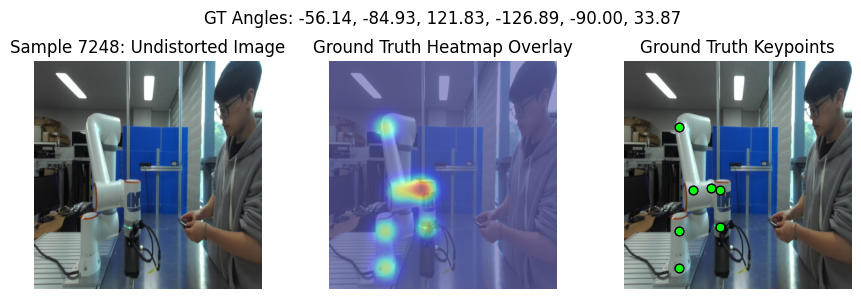

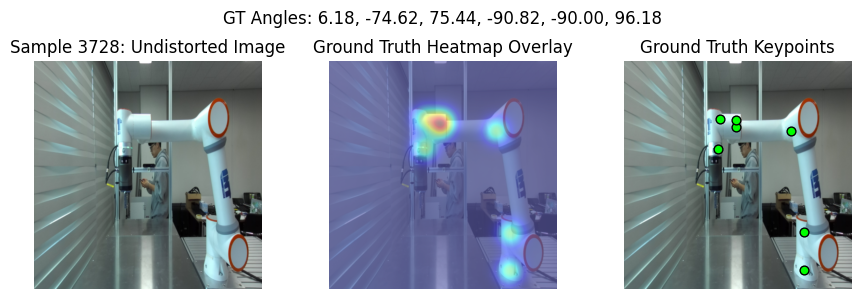

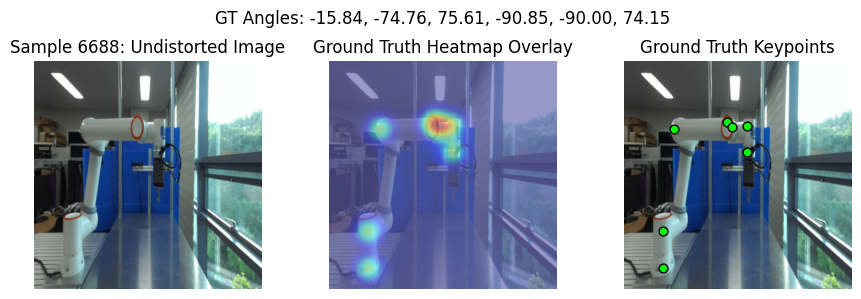


--- Starting Training ---


Epoch 1 [Train]:   0%|          | 0/55 [00:25<?, ?it/s]


TypeError: Caught TypeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
  File "/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_194756/1160951641.py", line 18, in forward
    predicted_heatmaps = self.keypoint_head(dino_features, cnn_stem_features)
  File "/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
TypeError: RefinedSimpleKeypointHead.forward() takes 2 positional arguments but 3 were given


In [ ]:
# ==============================================================================
# 3. 학습 및 검증 루프 (Training & Validation Loop)
# ==============================================================================
def setup(model_name, dataset_pairs, batch_size, val_split=0.2, num_epochs=100):
    """학습에 필요한 모든 구성 요소를 준비합니다."""
    print("--- Setting up the environment ---")
    
    # 1. Transform 정의
    dino_model_for_config = timm.create_model(model_name, pretrained=True)
    config = dino_model_for_config.default_cfg
    transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])
    print(f"Image transform created for input size: {config['input_size'][-2:]}")

    # 2. Dataset 및 DataLoader 준비
    full_dataset = RobotPoseDataset(pairs=dataset_pairs, transform=transform)
    
    # Train / Validation 분리
    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    print(f"Dataset split: {len(train_dataset)} training samples, {len(val_dataset)} validation samples.")

    # 3. 모델, 손실 함수, 옵티마이저 준비
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DINOv2PoseEstimator(model_name)

    # DINOv2 백본은 동결하고 헤드만 학습 (선택 사항)
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    if torch.cuda.device_count() > 1:
        print(f"Let's use {torch.cuda.device_count()} GPUs!")
        # nn.DataParallel로 모델을 감싸줍니다.
        model = nn.DataParallel(model)
        
    model.to(device)
        
    crit_kpt = nn.MSELoss()
    # 사용법 (setup 함수 내에서)
    # crit_kpt = FocalHeatmapLoss()
    crit_ang = nn.SmoothL1Loss(beta=1.0)

    model_to_access = model.module if isinstance(model, nn.DataParallel) else model
    
    optimizer_kpt = torch.optim.AdamW(model_to_access.keypoint_head.parameters(), lr=0.005)
    optimizer_ang = torch.optim.AdamW(model_to_access.angle_head.parameters(), lr=0.005)



    scheduler_kpt = CosineAnnealingLR(optimizer_kpt, T_max=num_epochs, eta_min=1e-6)
    scheduler_ang = CosineAnnealingLR(optimizer_ang, T_max=num_epochs, eta_min=1e-6)
    # --------------------------------------------------------------------------
    
    print(f"Model, losses, and optimizers are ready. Using device: {device}")
    
    # ✅ 반환 값에 옵티마이저 2개 추가
    return model, train_loader, val_loader, crit_kpt, crit_ang, optimizer_kpt, optimizer_ang, scheduler_kpt, scheduler_ang, device, config

def train_one_epoch(model, loader, optimizer_kpt, optimizer_ang, crit_kpt, crit_ang, device, loss_weight_kpt=1.0, epoch_num=0):
    model.train()
    total_loss_kpt = 0
    total_loss_ang = 0
    
    loop = tqdm(loader, desc=f"Epoch {epoch_num} [Train]")
    
    for images, heatmaps, angles in loop:
        images, heatmaps, angles = images.to(device), heatmaps.to(device), angles.to(device)
        
        pred_heatmaps, pred_angles = model(images)
        
        # --- Keypoint Head 업데이트 ---
        optimizer_kpt.zero_grad()
        loss_kpt = crit_kpt(pred_heatmaps, heatmaps) * loss_weight_kpt
        loss_kpt.backward()
        optimizer_kpt.step()
        
        # --- Angle Head 업데이트 ---
        optimizer_ang.zero_grad()
        loss_ang = crit_ang(pred_angles, angles)
        loss_ang.backward()
        optimizer_ang.step()
        
        # 손실 기록
        total_loss_kpt += loss_kpt.item()
        total_loss_ang += loss_ang.item()
        
        # 진행률 표시줄에 각 손실 값을 업데이트
        loop.set_postfix(loss_ang=loss_ang.item(), loss_kpt=loss_kpt.item())
        
    # 평균 손실 반환
    avg_loss_kpt = total_loss_kpt / len(loader)
    avg_loss_ang = total_loss_ang / len(loader)
    return avg_loss_kpt, avg_loss_ang

def validate(model, loader, crit_kpt, crit_ang, device, loss_weight_kpt=1.0, epoch_num=0):
    model.eval()
    total_loss = 0
    loop = tqdm(loader, desc=f"Epoch {epoch_num} [Validate]", leave=False) # leave=False로 설정하면 완료 후 바가 사라짐
    
    with torch.no_grad():
        for images, heatmaps, angles in loop:
            images, heatmaps, angles = images.to(device), heatmaps.to(device), angles.to(device)
            
            pred_heatmaps, pred_angles = model(images)
            
            loss_kpt = crit_kpt(pred_heatmaps, heatmaps) * loss_weight_kpt
            loss_ang = crit_ang(pred_angles, angles)
            loss = loss_kpt + loss_ang
            
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
    return total_loss / len(loader)

# ==============================================================================
# 4. 메인 실행부 (Main Execution)
# ==============================================================================
import time

if __name__ == '__main__':
    
    hyperparameters = {
        'model_name': 'vit_base_patch14_dinov2.lvd142m',
        'batch_size': 150,
        'num_epochs': 100,
        'val_split': 0.1,
        'loss_weight_kpt': 10000.0, # FocalLoss를 사용하므로 10로 되돌리거나 조절
        'lr_kpt': 0.005,
        'lr_ang': 0.005,
    }
    CHECKPOINT_PATH = '/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/model/checkpoint.pth'

    run = wandb.init(
        project="robot-pose-estimation", # wandb 프로젝트 이름
        config=hyperparameters,          # 하이퍼파라미터 저장
        name=f"run_{time.strftime('%Y%m%d_%H%M%S')}" # 실행 이름 (선택 사항)
    )
    
    # --- 학습 환경 설정 ---
    model, train_loader, val_loader, crit_kpt, crit_ang, optimizer_kpt, optimizer_ang, scheduler_kpt, scheduler_ang, device, config = setup(
        hyperparameters['model_name'], dataset_pairs, hyperparameters['batch_size'], 
        hyperparameters['val_split'], num_epochs=hyperparameters['num_epochs']
    )
    wandb.watch(model, log="all", log_freq=100)
    
    start_epoch = 0
    best_val_loss = float('inf')

    if os.path.exists(CHECKPOINT_PATH):
        print(f"✅ Found checkpoint at '{CHECKPOINT_PATH}'. Resuming training.")
        # 체크포인트 로드 (CPU에 먼저 로드하여 메모리 오류 방지)
        checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')
        
        # DataParallel 래핑 여부에 따라 state_dict 로드
        model_to_load = model.module if isinstance(model, nn.DataParallel) else model
        model_to_load.load_state_dict(checkpoint['model_state_dict'])
        
        # 옵티마이저 상태 로드
        optimizer_kpt.load_state_dict(checkpoint['optimizer_kpt_state_dict'])
        optimizer_ang.load_state_dict(checkpoint['optimizer_ang_state_dict'])
        
        # 학습 변수 복원
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        
        print(f"   -> Resuming from epoch {start_epoch}, with best validation loss: {best_val_loss:.6f}")
    else:
        print("ℹ️ No checkpoint found. Starting training from scratch.")
    # --------------------------------------------------------------------------

    visualize_dataset_sample(train_loader.dataset.dataset, config, num_samples=3)

    # --- 학습 시작 ---
    print("\n--- Starting Training ---")

    # ✅ --- 2. 학습 루프 시작점 수정 ---
    for epoch in range(start_epoch, hyperparameters['num_epochs']):
        train_loss_kpt, train_loss_ang = train_one_epoch(
            model, train_loader, optimizer_kpt, optimizer_ang, crit_kpt, crit_ang, device, loss_weight_kpt=hyperparameters['loss_weight_kpt'], epoch_num=epoch+1
        )
        val_loss = validate(model, val_loader, crit_kpt, crit_ang, device, loss_weight_kpt=hyperparameters['loss_weight_kpt'], epoch_num=epoch+1)
        
        print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']} Summary -> Train Losses [Kpt: {train_loss_kpt:.6f}, Ang: {train_loss_ang:.6f}], Avg Val Loss: {val_loss:.6f}")
        
        # ✅ --- 3. 체크포인트 저장 로직 수정 ---
        # --------------------------------------------------------------------------
        # 현재 에폭의 상태를 체크포인트로 저장 (매 에폭마다 덮어쓰기)
        state_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': state_to_save,
            'optimizer_kpt_state_dict': optimizer_kpt.state_dict(),
            'optimizer_ang_state_dict': optimizer_ang.state_dict(),
            'best_val_loss': best_val_loss,
        }
        torch.save(checkpoint, CHECKPOINT_PATH)
        
        scheduler_kpt.step()
        scheduler_ang.step()

        current_lr_kpt = optimizer_kpt.param_groups[0]['lr']
        current_lr_ang = optimizer_ang.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']} Summary -> Train Losses [Kpt: {train_loss_kpt:.6f}, Ang: {train_loss_ang:.6f}], Avg Val Loss: {val_loss:.6f}")
        print(f"  -> Current LRs [Kpt: {current_lr_kpt:.6f}, Ang: {current_lr_ang:.6f}]")
        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss_kpt": train_loss_kpt,
            "train_loss_ang": train_loss_ang,
            "avg_val_loss": val_loss,
            "lr_kpt": current_lr_kpt,
            "lr_ang": current_lr_ang
        })

        # 최고 성능 모델은 별도로 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # 위에서 이미 저장했으므로, 여기서는 최고 성능 모델을 복사해서 따로 보관
            torch.save(state_to_save, 'best_pose_estimator_model.pth')
            print(f"  -> 🎉 New best model saved with validation loss: {best_val_loss:.6f}")
            prediction_fig = visualize_predictions(
                model, val_loader.dataset, device, config, epoch_num=epoch + 1, num_samples=3
            )
            wandb.log({"validation_predictions": wandb.Image(prediction_fig)})
            # visualize_predictions(model, val_loader.dataset, device, config, epoch_num=epoch + 1, num_samples=3)
            plt.close(prediction_fig) # 메모리 누수 방지를 위해 figure 닫기
        # --------------------------------------------------------------------------

    print("\n--- Training Finished ---")
    print(f"🏆 Best validation loss: {best_val_loss:.6f}")
    print("Model and checkpoint saved to 'best_pose_estimator_model.pth' and 'checkpoint.pth'")
    
    run.finish()

In [ ]:
import torch
import torch.nn as nn
import timm
from PIL import Image
from torchvision import transforms
import numpy as np
import os

# --- 2. Multi-View Fusion Module using Cross-Attention ---
class MultiViewFusion(nn.Module):
    """
    Fuses features from multiple views using self-attention, which acts
    as cross-attention when tokens from all views are concatenated.
    """
    def __init__(self, feature_dim=768, num_heads=8, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        # The core component: Multi-Head Attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim=feature_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True  # Expects input shape [B, N, D]
        )
        # Standard Transformer components
        self.layer_norm1 = nn.LayerNorm(feature_dim)
        self.layer_norm2 = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * 4, feature_dim),
            nn.Dropout(dropout)
        )

    def forward(self, view_features):
        # view_features: A list of tensors, e.g., [view1_tokens, view2_tokens, view3_tokens]
        # Each tensor has shape [1, NumPatches, FeatureDim]
        
        # Concatenate tokens from all views into a single sequence
        # Shape becomes [1, TotalNumPatches, FeatureDim]
        all_tokens = torch.cat(view_features, dim=1)
        
        # --- Self-Attention as Cross-Attention ---
        # The attention mechanism will calculate scores between every token pair.
        # This allows tokens from view 1 to attend to tokens from view 2 and 3,
        # effectively performing cross-view attention.
        attn_output, _ = self.attention(
            query=all_tokens,
            key=all_tokens,
            value=all_tokens
        )
        
        # First residual connection and layer norm
        x = self.layer_norm1(all_tokens + attn_output)
        
        # MLP part
        mlp_output = self.mlp(x)
        
        # Second residual connection and layer norm
        fused_features = self.layer_norm2(x + mlp_output)
        
        return fused_features

# --- 3. Main Execution Logic ---
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize models
    backbone = DINOv2Backbone().to(device).eval()
    # The feature dimension of DINOv2-Base is 768
    fusion_module = MultiViewFusion(feature_dim=768).to(device).eval()

    # Define image paths
    image_paths = [
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/left/zed_38007749_left_1748249112.409.jpg",
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/right/zed_34850673_left_1748249112.387.jpg",
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/top/zed_30779426_left_1748249112.398.jpg"
    ]

    # --- Step A: Extract features for each view ---
    print("\n--- 1. Extracting features from each view ---")
    list_of_features = []
    for path in image_paths:
        print(f"Processing: {os.path.basename(path)}")
        patch_tokens = backbone(path)
        list_of_features.append(patch_tokens)
        print(f"  > Extracted feature shape: {patch_tokens.shape}")

    # --- Step B: Fuse features using the attention module ---
    print("\n--- 2. Fusing features with Multi-Head Cross-Attention ---")
    # The module expects a list of feature tensors
    fused_representation = fusion_module(list_of_features)

    # --- Step C: Show the final result ---
    print("\n--- 3. Final Fused Representation ---")
    print(f"Shape of the final fused feature map: {fused_representation.shape}")
    print("\nThis fused representation is now ready for the prediction heads (Keypoints and Angles).")
    

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from PIL import Image
from torchvision import transforms
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt

# --- Constants for the Model ---
NUM_JOINTS = 7
FEATURE_DIM = 768
HEATMAP_SIZE = (128, 128)

# ===================================================================
# 🏗️ STEP 1: DEFINE ALL MODEL COMPONENTS
# ===================================================================

class DINOv2Backbone(nn.Module):
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        self.config = self.model.default_cfg
        self.transform = transforms.Compose([
            transforms.Resize(self.config['input_size'][-2:]),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.config['mean'], std=self.config['std'])
        ])

    def forward(self, image_path):
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0).to(next(self.model.parameters()).device)
        features = self.model.forward_features(input_tensor)
        return features[:, 1:, :]

class MultiViewFusion(nn.Module):
    def __init__(self, feature_dim=FEATURE_DIM, num_heads=8, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(feature_dim, num_heads, dropout=dropout, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(feature_dim)
        self.layer_norm2 = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 4), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(feature_dim * 4, feature_dim), nn.Dropout(dropout)
        )

    def forward(self, view_features):
        all_tokens = torch.cat(view_features, dim=1)
        attn_output, _ = self.attention(all_tokens, all_tokens, all_tokens)
        x = self.layer_norm1(all_tokens + attn_output)
        mlp_output = self.mlp(x)
        return self.layer_norm2(x + mlp_output)

class AngleHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_joints=NUM_JOINTS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512), nn.GELU(), nn.LayerNorm(512),
            nn.Linear(512, 256), nn.GELU(), nn.LayerNorm(256),
            nn.Linear(256, num_joints)
        )
    def forward(self, fused_features):
        global_features = fused_features.mean(dim=1)
        return self.mlp(global_features)

class KeypointHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_joints=NUM_JOINTS):
        super().__init__()
        self.reshape_size = 64
        upsample_channels = [256, 128, 64]
        layers = []
        in_channels = input_dim
        for out_channels in upsample_channels:
            layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.GELU(), nn.BatchNorm2d(out_channels)
            ])
            in_channels = out_channels
        layers.append(nn.ConvTranspose2d(in_channels, num_joints, kernel_size=4, stride=2, padding=1))
        self.upsampler = nn.Sequential(*layers)

    def forward(self, fused_features):
        tokens = fused_features[:, :self.reshape_size**2, :]
        b, n, d = tokens.shape
        h = w = int(np.sqrt(n))
        feature_map = tokens.permute(0, 2, 1).reshape(b, d, h, w)
        heatmaps = self.upsampler(feature_map)
        return F.interpolate(heatmaps, size=HEATMAP_SIZE, mode='bilinear', align_corners=False)

# ===================================================================
# 🤖 STEP 2: ASSEMBLE THE FULL MODEL
# ===================================================================

class RobotPoseEstimator(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = DINOv2Backbone()
        self.fusion_module = MultiViewFusion()
        self.angle_head = AngleHead()
        self.keypoint_head = KeypointHead()

    def forward(self, image_paths, device):
        timings = {}

        # --- Part A: Backbone Feature Extraction ---
        start_time = time.time()
        list_of_features = [self.backbone(path) for path in image_paths]
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['A_Backbone_Extraction'] = time.time() - start_time
        
        # --- Part B: Multi-view Feature Fusion ---
        start_time = time.time()
        fused_features = self.fusion_module(list_of_features)
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['B_Feature_Fusion'] = time.time() - start_time
        
        # --- Part C: Prediction Heads ---
        start_time = time.time()
        predicted_angles = self.angle_head(fused_features)
        predicted_heatmaps = self.keypoint_head(fused_features)
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['C_Prediction_Heads'] = time.time() - start_time
        
        return predicted_angles, predicted_heatmaps, timings

# ===================================================================
# 🚀 STEP 3: RUN AND TIME THE FULL PIPELINE
# ===================================================================

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # --- Timed Step 1: Model Initialization ---
    print("--- 1. Initializing Full Model ---")
    start_time = time.time()
    full_model = RobotPoseEstimator().to(device).eval()
    if device.type == 'cuda': torch.cuda.synchronize()
    print(f"✅ Model initialization took: {time.time() - start_time:.4f} seconds\n")

    # Define image paths
    image_paths = [
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/left/zed_38007749_left_1748248620.487.jpg",
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/right/zed_34850673_left_1748248620.483.jpg",
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/top/zed_30779426_left_1748248620.496.jpg"
    ]

    # --- Timed Step 2: Full Inference Pass ---
    print("--- 2. Running Full Inference Pass ---")
    start_time = time.time()
    with torch.no_grad():
        angles, heatmaps, timings = full_model(image_paths, device)
    if device.type == 'cuda': torch.cuda.synchronize()
    total_inference_time = time.time() - start_time
    
    print("✅ Full inference finished.\n")
    print("--- Performance Breakdown ---")
    for step, duration in timings.items():
        print(f"  - {step}: {duration:.4f} seconds")
    print(f"  ---------------------------------")
    print(f"  Total Inference Time: {total_inference_time:.4f} seconds")
    print(f"  Estimated FPS: {1 / total_inference_time:.2f}\n")
    
    print("--- Output Shapes ---")
    print(f"  - Predicted Angles Shape: {angles.shape}")
    print(f"  - Predicted Heatmaps Shape: {heatmaps.shape}")